# **사전 학습된 모델을 활용한 추론 (Inference with Pretrained Network)**

## 1. 라이브러리 불러오기

In [ ]:
import os

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchsummary import summary
from tqdm import tqdm

## 2. Custom Dataloader 생성

In [ ]:
########## Custom DataLoader ##########
class PyTorchCustomDataset(Dataset):
  def __init__(self, root_dir="cats_and_dogs_filtered/train", transform=None):
    self.image_abs_path = root_dir
    self.transform = transform
    self.label_list = os.listdir(self.image_abs_path)
    self.label_list.sort()
    self.x_list = []
    self.y_list = []
    for label_index, label_str in enumerate(self.label_list):
      img_path = os.path.join(self.image_abs_path, label_str)
      img_list = os.listdir(img_path)
      for img in img_list:
        self.x_list.append(os.path.join(img_path, img))
        self.y_list.append(label_index)
    pass

  def __len__(self):
    return len(self.x_list)

  def __getitem__(self, idx):
    image = Image.open(self.x_list[idx])
    if image.mode != "RGB":
      image = image.convert('RGB')
    if self.transform is not None:
      image = self.transform(image)
    return image, torch.tensor(self.y_list[idx]).type(torch.LongTensor)

  def __save_label_map__(self, dst_text_path="label_map.txt"):
    label_list = self.label_list
    f = open(dst_text_path, 'w')
    for i in range(len(label_list)):
      f.write(label_list[i]+'\n')
    f.close()
    pass

  def __num_classes__(self):
    return len(self.label_list)

## 3. 시험 데이터셋 다운로드

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -qq cats_and_dogs_filtered.zip

--2025-07-08 04:48:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 192.178.163.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   281MB/s    in 0.2s    

2025-07-08 04:48:41 (281 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### 데이터셋 시각화

In [ ]:
sample_cat = Image.open("/content/cats_and_dogs_filtered/validation/cats/cat.2000.jpg")
sample_dog = Image.open("/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg")

#### 고양이

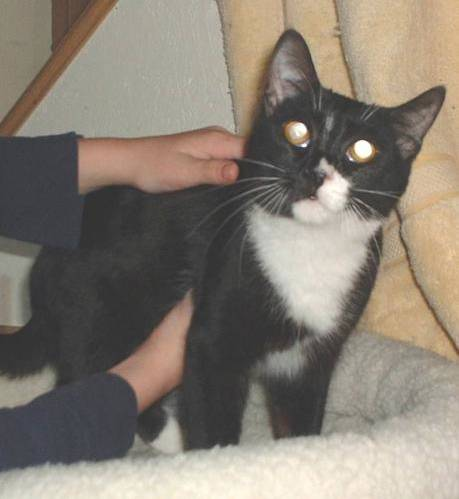

In [ ]:
sample_cat

#### 강아지

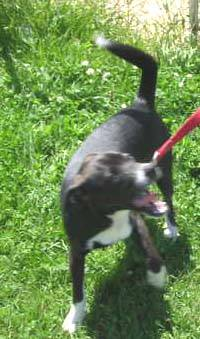

In [ ]:
sample_dog

## PyTorch Pretrained Models

### ImageNet에 훈련된 모델 리스트
*   https://docs.pytorch.org/vision/0.21/models.html




### 사전 학습된 모델 불러오기

In [ ]:
from torchvision.models import alexnet, vgg16_bn, resnet50
from torchvision.models import AlexNet_Weights, VGG16_BN_Weights, ResNet50_Weights

In [ ]:
# Check Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device : {device}")

Current Device : cuda


### 가중치 불러오기

In [ ]:
model_alexnet = alexnet(AlexNet_Weights.DEFAULT)
model_vgg16_bn = vgg16_bn(VGG16_BN_Weights.DEFAULT)
model_resnet50 = resnet50(ResNet50_Weights.DEFAULT)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 189MB/s]
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [ ]:
model_alexnet = model_alexnet.eval().to(device)
model_vgg16_bn = model_vgg16_bn.eval().to(device)
model_resnet50 = model_resnet50.eval().to(device)

### 모델 구조 시각화

In [ ]:
img_channels, img_size = 3, 224

#### AlexNet

In [ ]:
summary(model_alexnet, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

#### VGG16 with Batch-Norm.

In [ ]:
summary(model_vgg16_bn, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

#### ResNet50

In [ ]:
summary(model_resnet50, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Freeze Model Parameters

In [ ]:
for p in model_alexnet.parameters() :
  p.requires_grad = False

summary(model_alexnet, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
for p in model_vgg16_bn.parameters() :
  p.requires_grad = False

summary(model_vgg16_bn, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
for p in model_resnet50.parameters() :
  p.requires_grad = False

summary(model_resnet50, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## 사전 학습된 모델을 활용한 추론 진행

In [ ]:
########## Inference Code ##########
def inference(model, src="cats_and_dogs_filtered/validation", img_size=224, img_channels=3) :
  # Load Dataset
  transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])]) # ImageNet의 RGB 통계량

  # Create Custom Dataset Instance
  test_dataset = PyTorchCustomDataset(src, transform)

  # Create DataLoader
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

  # Check Device
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f"Current Device : {device}")

  # Create Model Instance
  model = model.eval().to(device)

  # Summarize Model
  summary(model, (img_channels, img_size, img_size))

  # Create List Instance
  cat_label_dict, dog_label_dict = {}, {}

  # Inference
  with torch.no_grad() :
    # Create TQDM Bar Instance
    test_bar = tqdm(test_loader)

    for data in test_bar :
      img, label = data
      img = img.to(device)
      pred = model(img)
      pred = torch.argmax(pred, dim=-1).cpu().item()

      if label == 0 : # 0 for Cat / 1 for Dog
        if pred not in cat_label_dict.keys() :
            cat_label_dict[pred] = 1
        else :
            cat_label_dict[pred] += 1
      else :
        if pred not in dog_label_dict.keys() :
            dog_label_dict[pred] = 1
        else :
            dog_label_dict[pred] += 1

      # Show Inference Status
      test_bar.set_description(desc=f"[Inference]")

  # Sort by Keys
  cat_label_dict_sorted = sorted(cat_label_dict.items(), key=lambda x:x[1], reverse=True)
  dog_label_dict_sorted = sorted(dog_label_dict.items(), key=lambda x:x[1], reverse=True)
  print()
  print(f"Cat Predictions : {cat_label_dict_sorted}")
  print(f"Dog Predictions : {dog_label_dict_sorted}")

### ImageNet Class Index (Number) List
*   https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

### AlexNet

In [ ]:
inference(model_alexnet)

Current Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d

[Inference]: 100%|██████████| 1000/1000 [00:08<00:00, 118.39it/s]


Cat Predictions : [(285, 85), (281, 80), (283, 52), (223, 28), (282, 20), (284, 16), (332, 14), (250, 11), (157, 8), (227, 7), (199, 7), (151, 6), (534, 6), (174, 6), (287, 5), (333, 5), (232, 5), (359, 4), (264, 4), (230, 4), (261, 4), (286, 4), (263, 3), (338, 3), (552, 3), (258, 3), (259, 3), (224, 3), (195, 3), (229, 2), (508, 2), (257, 2), (249, 2), (192, 2), (361, 2), (539, 2), (588, 2), (186, 2), (158, 2), (198, 2), (245, 2), (106, 2), (358, 2), (265, 2), (463, 2), (162, 2), (700, 2), (278, 2), (389, 1), (335, 1), (171, 1), (235, 1), (797, 1), (556, 1), (208, 1), (760, 1), (568, 1), (248, 1), (212, 1), (897, 1), (739, 1), (431, 1), (280, 1), (728, 1), (103, 1), (372, 1), (239, 1), (164, 1), (193, 1), (217, 1), (742, 1), (244, 1), (577, 1), (876, 1), (270, 1), (166, 1), (253, 1), (218, 1), (383, 1), (187, 1), (652, 1), (156, 1), (861, 1), (516, 1), (231, 1), (277, 1), (191, 1), (260, 1), (885, 1), (247, 1), (152, 1), (777, 1), (222, 1), (465, 1), (279, 1), (357, 1), (269, 1), (8

### VGG16 with Batch-Norm.

In [ ]:
inference(model_vgg16_bn)

Current Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d

[Inference]: 100%|██████████| 1000/1000 [00:14<00:00, 69.57it/s]


Cat Predictions : [(281, 157), (285, 136), (283, 59), (282, 27), (284, 23), (287, 18), (223, 8), (332, 4), (434, 4), (750, 4), (261, 3), (700, 3), (250, 3), (463, 3), (478, 3), (258, 2), (588, 2), (904, 2), (824, 2), (264, 2), (230, 2), (742, 2), (361, 1), (253, 1), (811, 1), (551, 1), (676, 1), (822, 1), (279, 1), (529, 1), (876, 1), (240, 1), (789, 1), (465, 1), (356, 1), (277, 1), (910, 1), (453, 1), (885, 1), (564, 1), (804, 1), (151, 1), (259, 1), (174, 1), (338, 1), (526, 1), (743, 1), (797, 1), (534, 1), (521, 1), (278, 1), (186, 1), (539, 1)]
Dog Predictions : [(208, 40), (235, 22), (180, 22), (234, 18), (207, 15), (151, 15), (162, 14), (209, 12), (246, 12), (179, 11), (227, 10), (260, 9), (161, 9), (219, 9), (168, 9), (273, 9), (195, 8), (225, 8), (243, 7), (210, 7), (232, 7), (164, 7), (237, 7), (172, 7), (165, 6), (163, 6), (194, 6), (155, 6), (158, 6), (231, 6), (159, 5), (242, 5), (263, 5), (154, 5), (236, 5), (264, 5), (166, 5), (215, 5), (222, 4), (153, 4), (174, 4), (2

### ResNet50

In [ ]:
inference(model_resnet50)

Current Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d

[Inference]: 100%|██████████| 1000/1000 [00:12<00:00, 80.71it/s]


Cat Predictions : [(285, 178), (281, 127), (283, 50), (282, 35), (284, 22), (332, 17), (463, 7), (223, 5), (478, 4), (224, 3), (588, 3), (918, 3), (534, 3), (508, 2), (434, 2), (539, 2), (287, 2), (896, 2), (264, 2), (789, 1), (359, 1), (258, 1), (333, 1), (157, 1), (714, 1), (743, 1), (652, 1), (261, 1), (750, 1), (233, 1), (594, 1), (553, 1), (722, 1), (840, 1), (741, 1), (247, 1), (232, 1), (384, 1), (250, 1), (151, 1), (904, 1), (678, 1), (790, 1), (532, 1), (782, 1), (457, 1), (454, 1), (700, 1), (521, 1), (280, 1)]
Dog Predictions : [(208, 43), (227, 27), (235, 23), (180, 20), (151, 18), (207, 17), (234, 16), (179, 15), (168, 13), (205, 10), (162, 10), (232, 9), (243, 8), (209, 8), (219, 8), (244, 8), (158, 8), (273, 8), (166, 8), (170, 7), (242, 7), (161, 7), (164, 7), (225, 7), (231, 7), (246, 6), (237, 6), (195, 6), (236, 6), (250, 6), (165, 5), (194, 5), (212, 5), (211, 5), (172, 5), (260, 4), (155, 4), (204, 4), (265, 4), (254, 4), (167, 4), (171, 3), (159, 3), (153, 3), (1